In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
from dateutil import parser
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
import statsmodels.api as sm

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

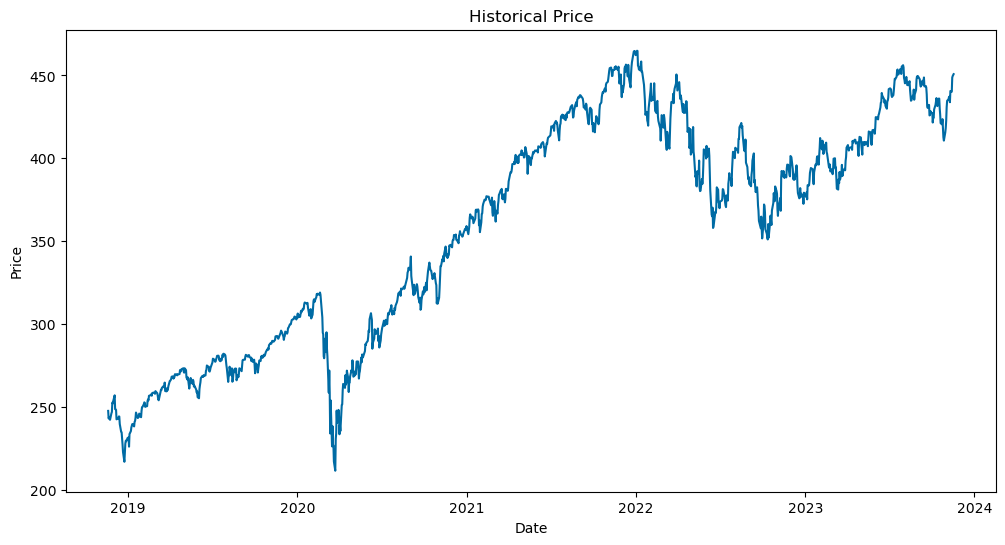

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=300.392829, mean2=415.009260, mean_percent_diff=38.155515
variance1=2024.993271, variance2=675.238305, var_percent_diff=-66.654788


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.263717
p-value: 0.645604
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.707036247220596, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.71
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


##### P-value < .05; therefore, not stationary

### Transform into stationary series

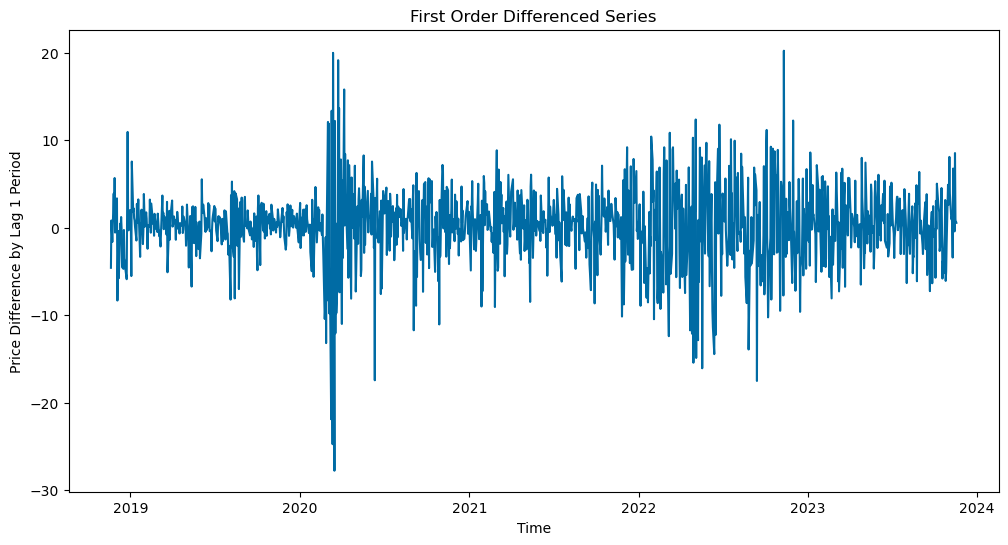

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.799172
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1238.5288376853343
MAE = 28.73207231994136
RMSE = 35.19273842265382
MAPE = 0.06662346398430072
r2 = -1.4190457404607835



/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


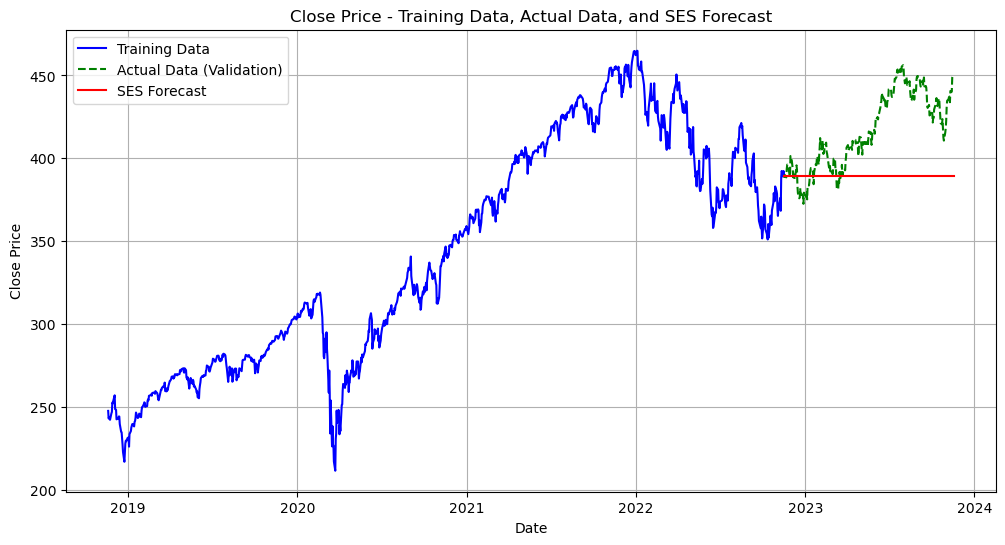

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

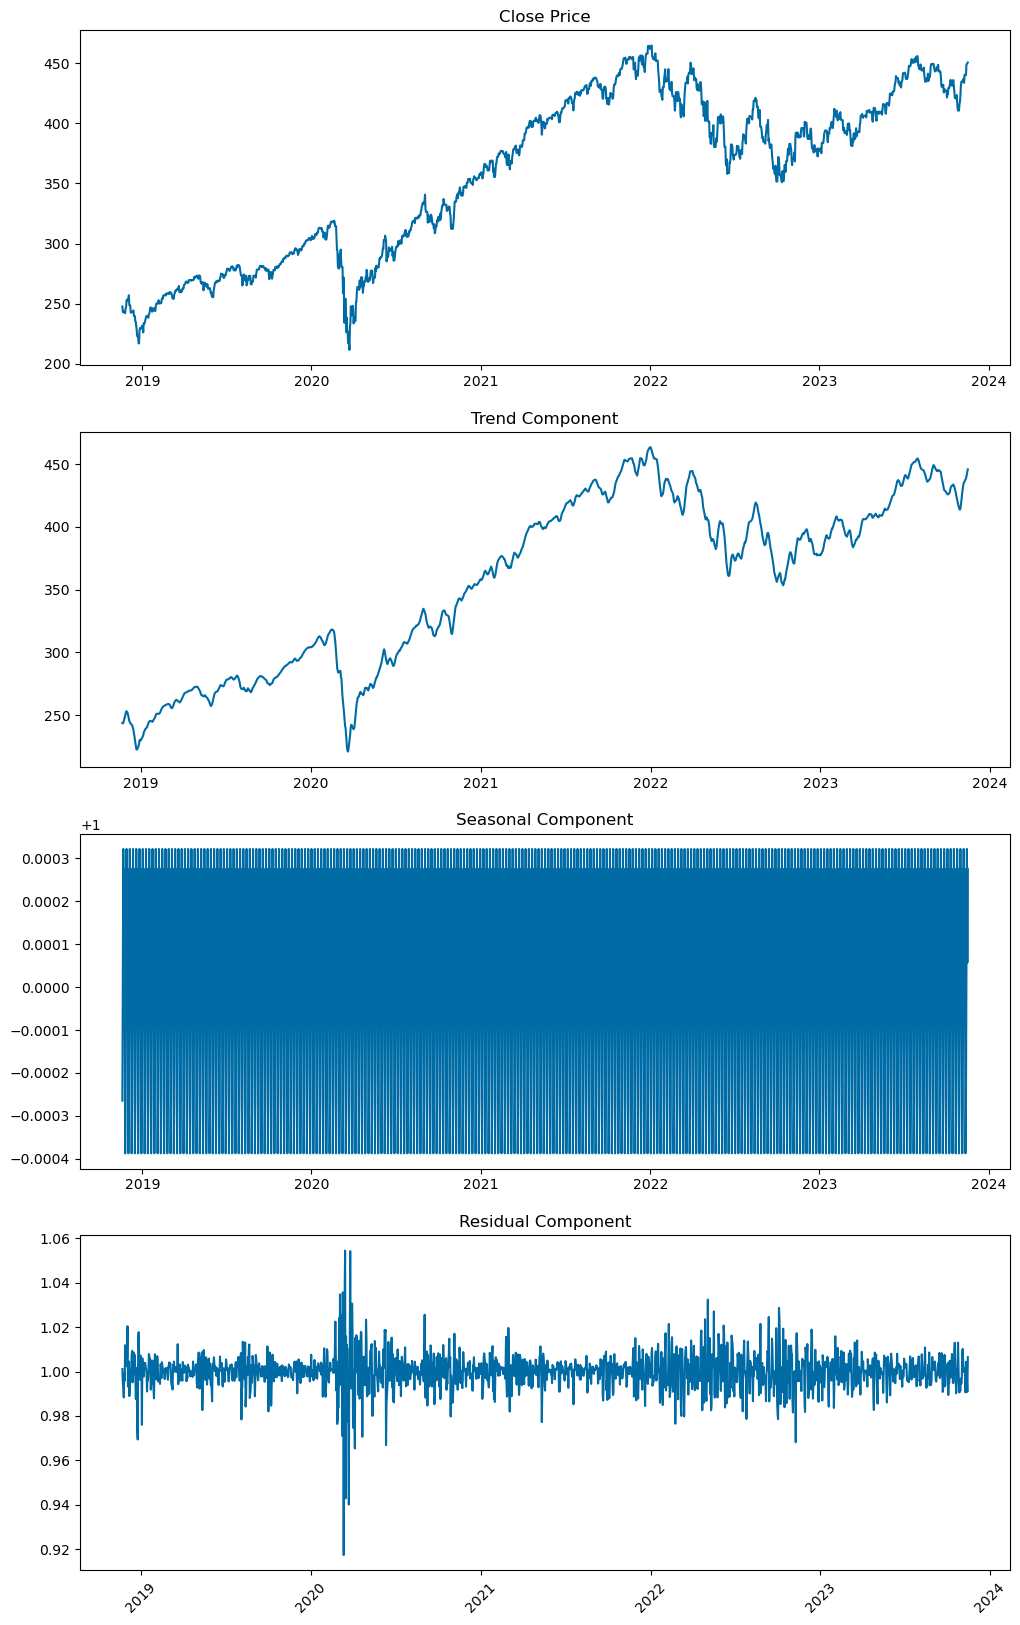

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

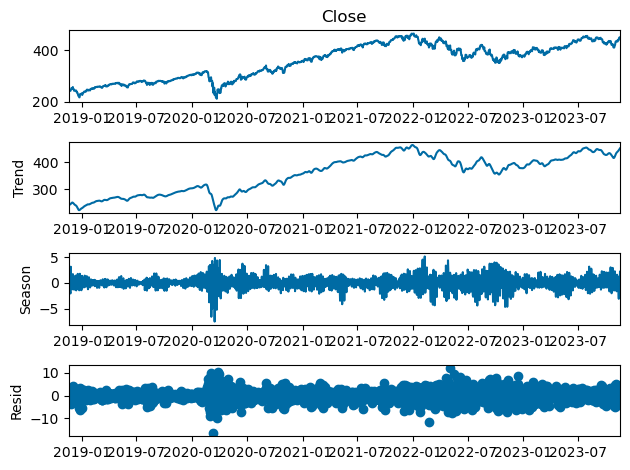

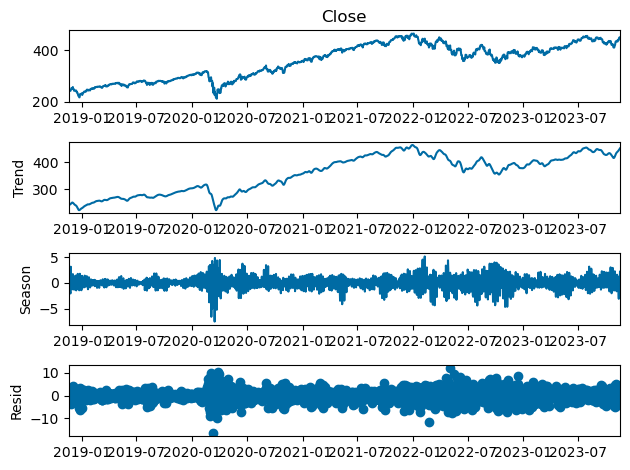

In [17]:
stl = STL(close).fit()
stl.plot()


### Autocorrelation - Raw Values

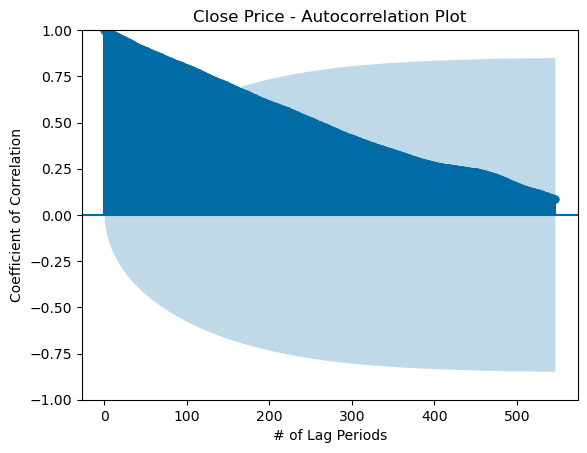

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


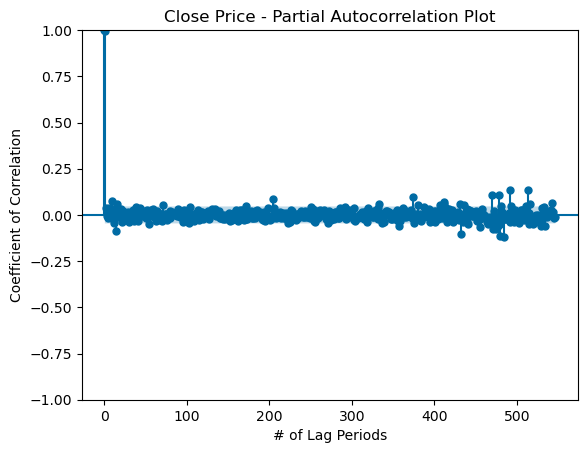

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

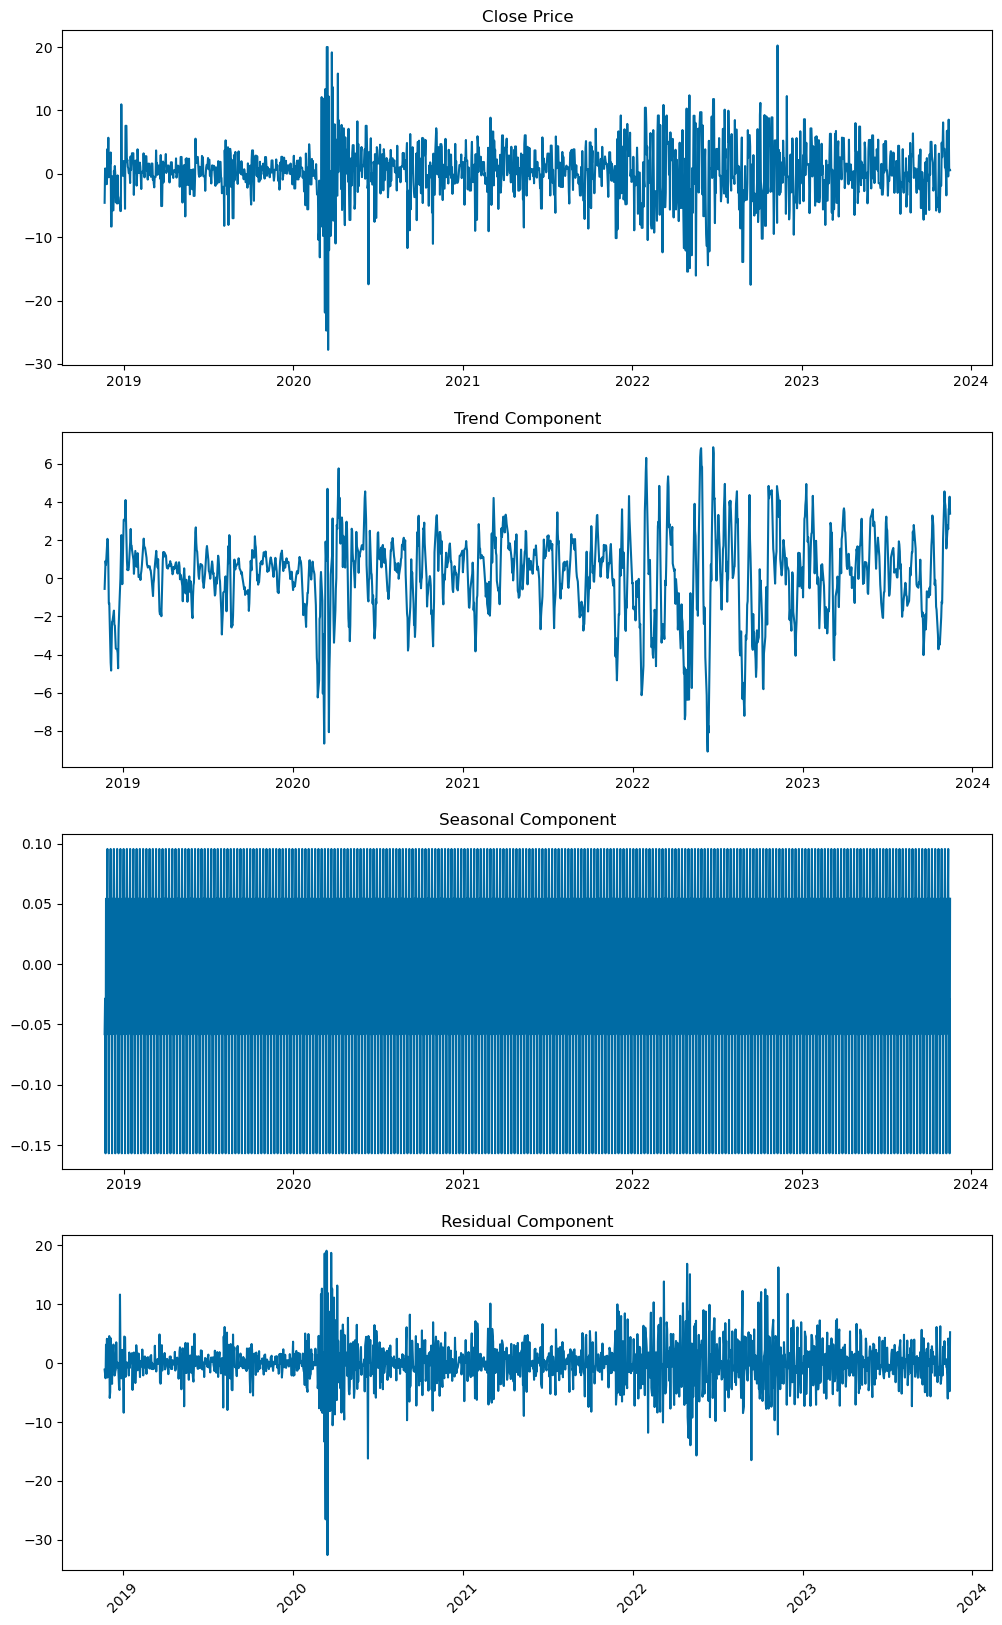

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

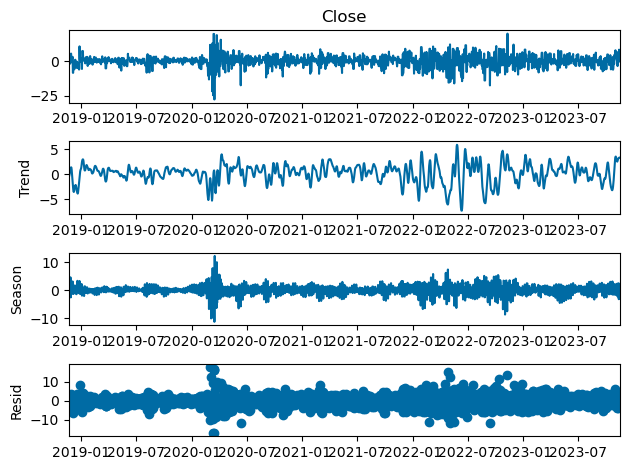

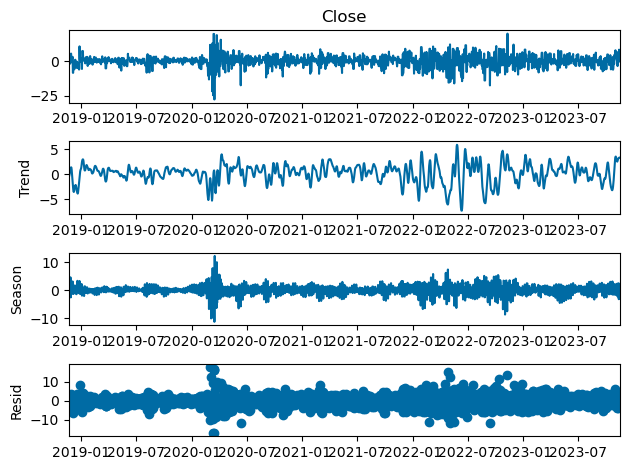

In [21]:
stl = STL(ts_lag_1).fit()
stl.plot()

### ACF on lag_1 period

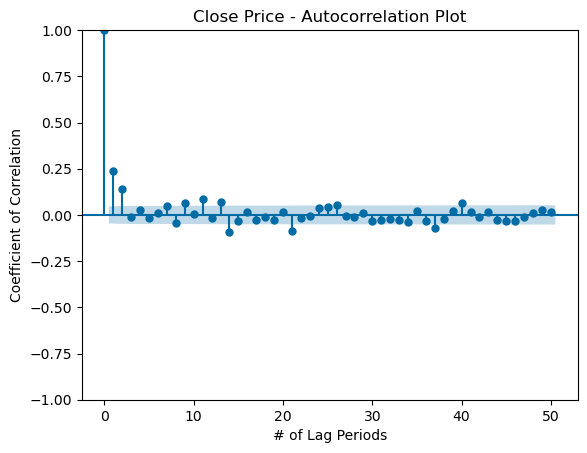

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Plot PACF on lag_1 period

/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


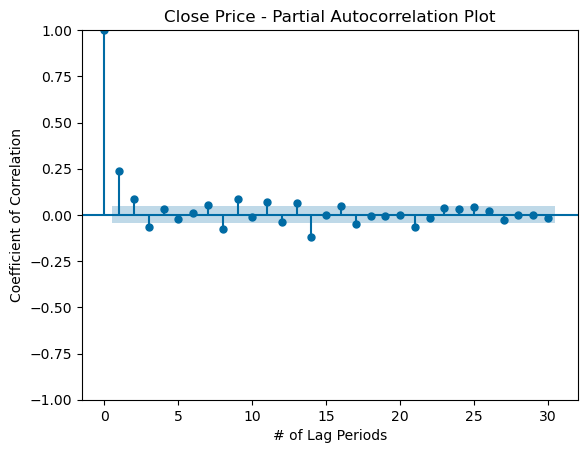

In [23]:
plot_pacf(ts_lag_1, lags=30)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1 and 14 periods.

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

In [24]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 14, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

Time Series Evaluation Metrics
MSE = 3915.7111165620518
MAE = 58.696854623780396
RMSE = 62.575643157398325
MAPE = 0.1401775597935
r2 = -6.64801271409793

None


/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


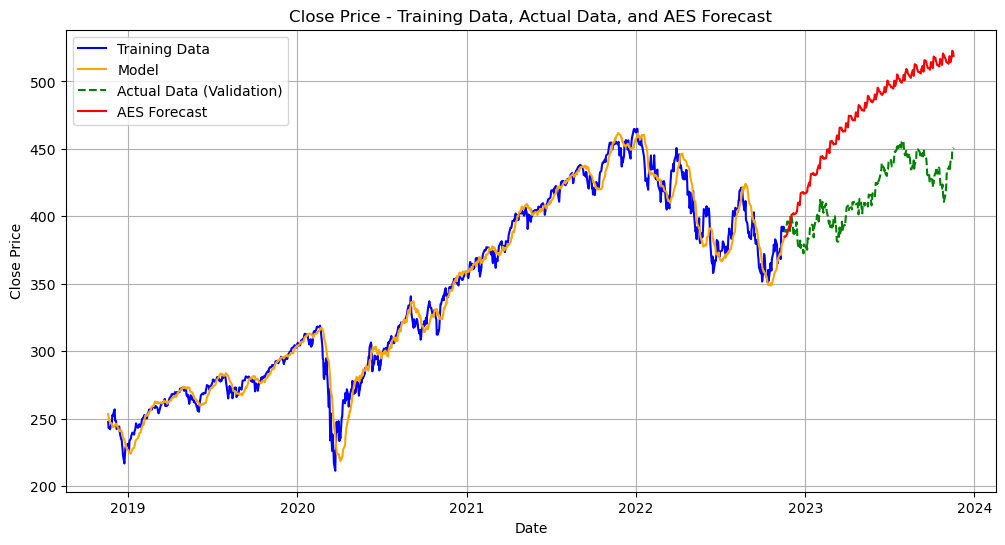

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

##### Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [26]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,0)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1459
Model:                ARIMA(14, 1, 0)   Log Likelihood               -2938.979
Date:                Fri, 17 Nov 2023   AIC                           5907.958
Time:                        21:45:58   BIC                           5987.231
Sample:                    11-19-2018   HQIC                          5937.532
                         - 11-16-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1311      0.031     -4.194      0.000      -0.192      -0.070
ar.L2         -0.1109      0.031     -3.562      0.000      -0.172      -0.050
ar.L3          0.1972      0.033      5.975      0.0

In [27]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

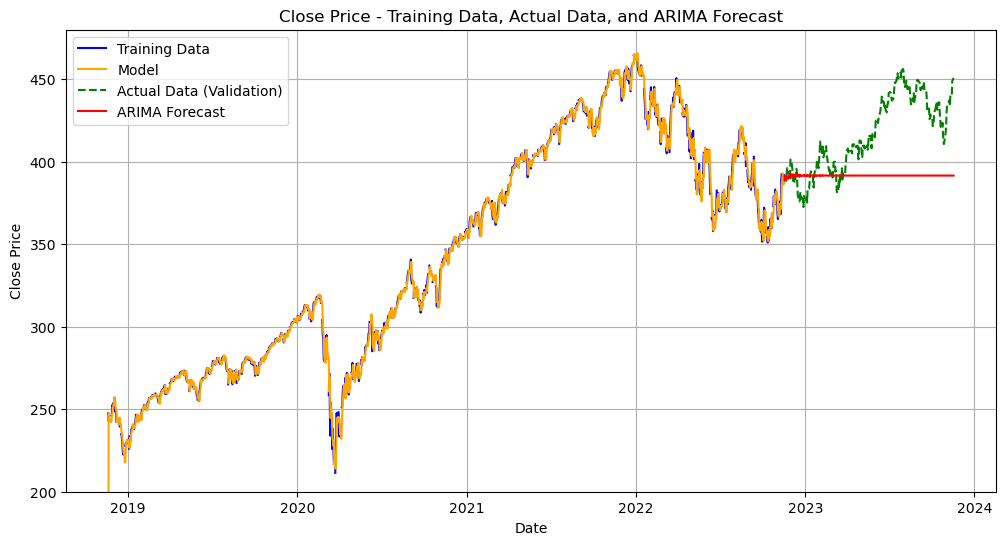

In [28]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [30]:
startdate = datetime(2020,3,16)
today = date.today()
enddate = today

In [31]:
indices = web.get_data_yahoo(y_symbols, start=startdate, end=enddate)
stocks = web.get_data_yahoo(stocks, start=startdate, end=enddate)

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [32]:
stocks

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7805450000
2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8370250000
2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8799300000
2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7956100000
2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9053950000
...,...,...,...,...,...,...
2023-11-10,4364.149902,4418.029785,4353.339844,4415.240234,4415.240234,3665080000
2023-11-13,4406.660156,4421.759766,4393.819824,4411.549805,4411.549805,3326240000
2023-11-14,4458.970215,4508.669922,4458.970215,4495.700195,4495.700195,4700350000


In [33]:
aapl.history(period='1mo')

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-18 00:00:00-04:00,434.190002,435.179993,429.089996,430.209991,93559800,0.0,0.0,0.0
2023-10-19 00:00:00-04:00,430.950012,432.820007,425.730011,426.429993,121323000,0.0,0.0,0.0
2023-10-20 00:00:00-04:00,425.980011,426.540009,421.079987,421.190002,123845800,0.0,0.0,0.0
2023-10-23 00:00:00-04:00,419.609985,424.450012,417.799988,420.459991,92035100,0.0,0.0,0.0
2023-10-24 00:00:00-04:00,422.649994,424.820007,420.739990,423.630005,78564200,0.0,0.0,0.0
2023-10-25 00:00:00-04:00,421.890015,421.920013,417.019989,417.549988,94223200,0.0,0.0,0.0
2023-10-26 00:00:00-04:00,416.450012,417.329987,411.600006,412.549988,115156800,0.0,0.0,0.0
2023-10-27 00:00:00-04:00,414.190002,414.600006,409.209991,410.679993,107367700,0.0,0.0,0.0
2023-10-30 00:00:00-04:00,413.559998,416.679993,412.220001,415.589996,86562700,0.0,0.0,0.0


In [34]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [35]:
opt_df = aapl.option_chain('2023-12-29')
call = opt_df.calls
put = opt_df.puts
put

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY231229P00270000,2023-11-17 20:50:12+00:00,270.0,0.03,0.03,0.04,-0.02,-40.000004,10.0,3888,0.523442,False,REGULAR,USD
1,SPY231229P00275000,2023-11-17 15:44:20+00:00,275.0,0.04,0.04,0.05,-0.01,-20.000004,4.0,3305,0.517583,False,REGULAR,USD
2,SPY231229P00280000,2023-11-17 15:46:26+00:00,280.0,0.05,0.04,0.05,0.01,25.000006,4.0,2645,0.500005,False,REGULAR,USD
3,SPY231229P00285000,2023-11-17 17:47:01+00:00,285.0,0.05,0.04,0.05,0.00,0.000000,11.0,2972,0.488286,False,REGULAR,USD
4,SPY231229P00290000,2023-11-16 20:57:35+00:00,290.0,0.07,0.05,0.06,0.00,0.000000,1.0,4015,0.480474,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,SPY231229P00520000,2023-10-06 19:26:13+00:00,520.0,89.30,84.39,85.46,0.00,0.000000,8.0,0,0.633365,True,REGULAR,USD
168,SPY231229P00525000,2023-05-02 14:13:12+00:00,525.0,112.78,0.00,0.00,0.00,0.000000,1.0,0,0.000010,True,REGULAR,USD
169,SPY231229P00530000,2023-08-22 19:12:46+00:00,530.0,90.87,98.39,99.27,0.00,0.000000,2.0,0,0.748995,True,REGULAR,USD
170,SPY231229P00540000,2023-11-09 18:04:13+00:00,540.0,104.25,88.85,90.02,0.00,0.000000,1.0,0,0.303718,True,REGULAR,USD


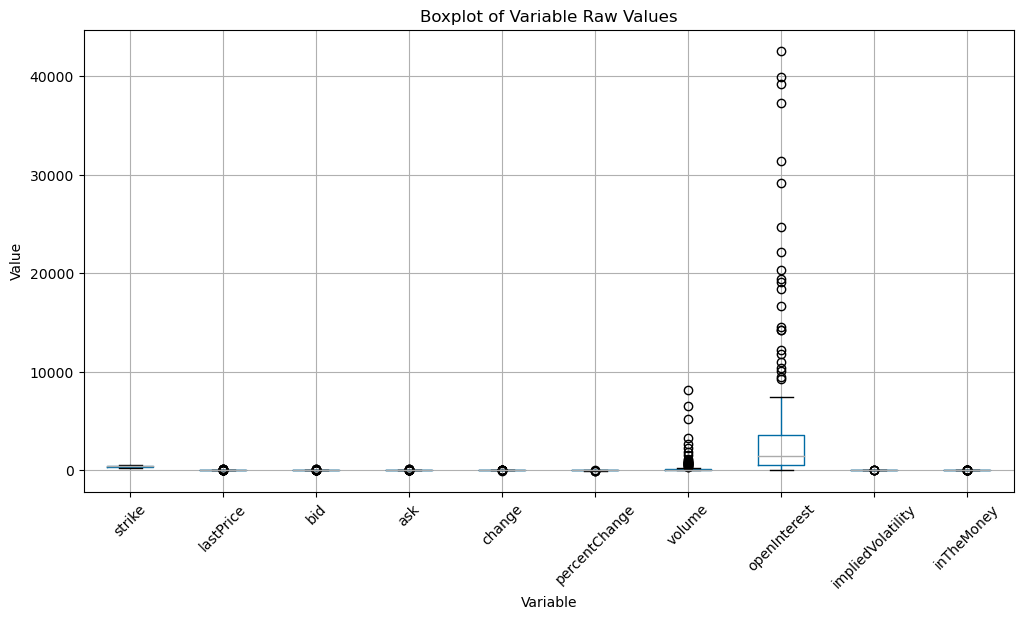

In [36]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [37]:
put.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,171.000000,172.000000,172.000000
mean,400.337209,8.201221,7.269244,7.448837,-0.330698,-6.146356,288.643275,4219.616279,0.254068
std,57.102168,21.002580,18.694765,19.001989,1.524454,8.140529,973.498250,7717.736091,0.143061
min,270.000000,0.030000,0.000000,0.000000,-14.740000,-52.897040,1.000000,0.000000,0.000010
25%,356.750000,0.230000,0.190000,0.200000,-0.172500,-10.169493,3.000000,578.500000,0.142304
50%,399.500000,0.565000,0.545000,0.555000,-0.030000,-6.507819,10.000000,1495.000000,0.227486
75%,442.250000,3.755000,3.635000,3.657500,0.000000,0.000000,117.500000,3605.500000,0.327033
max,550.000000,128.880000,118.800000,120.140000,0.020000,25.000006,8183.000000,42558.000000,0.886995


In [38]:
#df_temp

In [39]:
aapl.options

('2023-11-20',
 '2023-11-21',
 '2023-11-22',
 '2023-11-24',
 '2023-12-01',
 '2023-12-08',
 '2023-12-15',
 '2023-12-22',
 '2023-12-29',
 '2024-01-19',
 '2024-02-16',
 '2024-03-15',
 '2024-03-28',
 '2024-06-21',
 '2024-06-28',
 '2024-09-20',
 '2024-09-30',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19',
 '2026-01-16')

## Amazon  - Gabi in progress

In [40]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

{'currency': 'USD',
 'symbol': 'AMZN',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 863703000,
 'regularMarketTime': 1700254801,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 145.18,
 'chartPreviousClose': 143.56,
 'previousClose': 142.83,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1700211600,
   'end': 1700231400,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1700231400,
   'end': 1700254800,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1700254800,
   'end': 1700269200,
   'gmtoffset': -18000}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2023-11-13 00:00:00-05:00 2023-11-10 04:00:00-05:00 2023-11-10 09:30:00-05:00   
 2023-11-14 00:00:00-05:00 2023-11-13 04:00:0

In [41]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-11-19 00:00:00-05:00,78.850502,79.059502,75.167999,75.614502,155800000,0.0,0.0
2018-11-20 00:00:00-05:00,71.875000,76.737503,71.000000,74.773003,217576000,0.0,0.0
2018-11-21 00:00:00-05:00,77.149498,77.500000,75.750000,75.836502,114336000,0.0,0.0
2018-11-23 00:00:00-05:00,75.849998,76.809998,75.090500,75.102997,54152000,0.0,0.0
2018-11-26 00:00:00-05:00,76.949997,79.240501,76.210999,79.066498,125154000,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-13 00:00:00-05:00,142.080002,143.229996,140.669998,142.589996,35680600,0.0,0.0
2023-11-14 00:00:00-05:00,145.000000,147.259995,144.679993,145.800003,56674600,0.0,0.0
2023-11-15 00:00:00-05:00,147.059998,147.289993,142.589996,143.199997,63875700,0.0,0.0
2023-11-16 00:00:00-05:00,140.910004,143.320007,139.520004,142.830002,49653500,0.0,0.0
2023-11-17 00:00:00-05:00,142.660004,145.229996,142.539993,145.179993,49636700,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,126.121804,127.685257,124.447561,126.080452,7.814363e+07,0.0,0.015898
std,31.963937,32.246407,31.591222,31.876720,3.558626e+07,0.0,0.563884
min,67.300003,69.801498,65.349998,67.197998,1.762600e+07,0.0,0.000000
25%,94.556999,95.553001,93.317377,94.582752,5.437732e+07,0.0,0.000000
50%,124.120003,126.246498,122.927498,124.645000,6.720900e+07,0.0,0.000000
75%,158.346878,159.930752,156.224998,158.093746,9.236500e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,3.113460e+08,0.0,20.000000


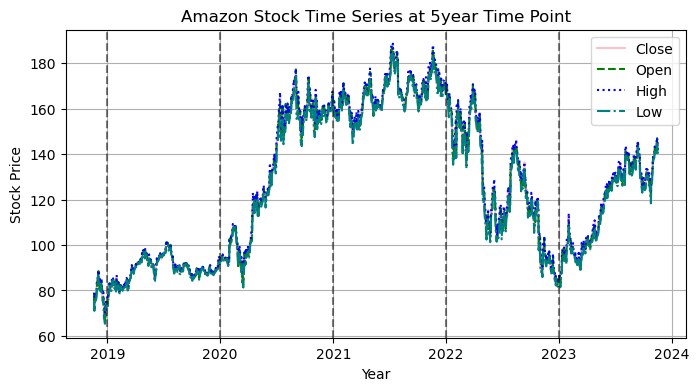

In [42]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(8, 4))
plt.plot(amzn_df['Close'], label='Close', color='pink')
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='teal', linestyle='dashdot')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [44]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.611948
p-value: 0.476953
Critical Values:
{'1%': -3.4348002311087007, '5%': -2.8635054856234343, '10%': -2.5678164050869863}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [45]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

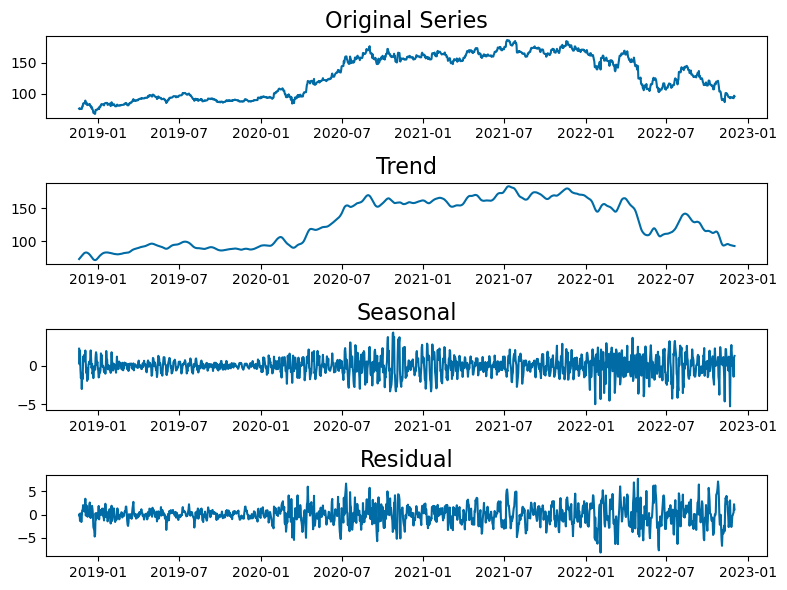

In [46]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt's Winter Smoothing

In [47]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()
amzn_train['Forecast'] = result_hw.fittedvalues

In [48]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 6))
#plt.plot(amzn_train, label='Actual Sales', marker='o')
amzn_train.index =  pd.to_datetime(amzn_train.index, format='%Y-%m-%d %H:%M:%S%:z')
amzn_train.index
#plt.plot(amzn_train['Forecast'], label='Forecast')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.title('Triple Exponential Smoothing Forecast')
#plt.legend()
#plt.show()

ValueError: ':' is a bad directive in format '%Y-%m-%d %H:%M:%S%:z'

<Figure size 1000x600 with 0 Axes>

In [49]:
import sys
print(sys.version)

3.8.18 (default, Sep 11 2023, 08:17:16) 
[Clang 14.0.6 ]


### Anomaly Detection

In [ ]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal
#plt.figure(figsize=(12,4))
#plt.plot(amzn_train, label='Original', color = 'teal')
#plt.plot(estimated, label ='Estimated', color = 'pink')

#plt.xlabel('Year')
#plt.ylabel('Stock Price')
#plt.title('Amazon Stock Time Series at 5year Time Point')
#plt.legend()
#plt.grid(True)
#plt.show()

In [ ]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

In [ ]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [ ]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

In [ ]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')

In [ ]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

### Transforming Time Series to Stationary

In [ ]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [ ]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

### Selecting a Model

In [ ]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [ ]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

In [ ]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

In [ ]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    